## 1. Get Data.

The information about the data set is in the "01 Data" folder. Check for the description of the columns.

In [103]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import KFold

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')


In [11]:
df = pd.read_csv(r'/Users/fdl/Repos/ML-ZoomCamp---Midterm-project/01 Data/new_train.csv')

df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

## 2. Data Check.

Exploration of the dataset (values for the different types of variables, missing values, max and min values).

In [12]:
# We can see if there are missing values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          32950 non-null  int64 
 1   job          32950 non-null  object
 2   marital      32950 non-null  object
 3   education    32950 non-null  object
 4   default      32950 non-null  object
 5   housing      32950 non-null  object
 6   loan         32950 non-null  object
 7   contact      32950 non-null  object
 8   month        32950 non-null  object
 9   day_of_week  32950 non-null  object
 10  duration     32950 non-null  int64 
 11  campaign     32950 non-null  int64 
 12  pdays        32950 non-null  int64 
 13  previous     32950 non-null  int64 
 14  poutcome     32950 non-null  object
 15  y            32950 non-null  object
dtypes: int64(5), object(11)
memory usage: 4.0+ MB


In [6]:
# Review columns data types
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numerical_columns = list(df.dtypes[df.dtypes != 'object'].index)

# number of unique values in categorical columns
df[categorical_columns].nunique()

job            12
marital         4
education       8
default         3
housing         3
loan            3
contact         2
month          10
day_of_week     5
poutcome        3
y               2
dtype: int64

In [7]:
# different values in categorical columns
for column in categorical_columns:
    print(f'Column: {column}')
    print(df[column].value_counts())
    print('-----------------------')

Column: job
job
admin.           8314
blue-collar      7441
technician       5400
services         3196
management       2345
retired          1366
entrepreneur     1160
self-employed    1099
housemaid         855
unemployed        798
student           711
unknown           265
Name: count, dtype: int64
-----------------------
Column: marital
marital
married     19953
single       9257
divorced     3675
unknown        65
Name: count, dtype: int64
-----------------------
Column: education
education
university.degree      9736
high.school            7596
basic.9y               4826
professional.course    4192
basic.4y               3322
basic.6y               1865
unknown                1397
illiterate               16
Name: count, dtype: int64
-----------------------
Column: default
default
no         26007
unknown     6940
yes            3
Name: count, dtype: int64
-----------------------
Column: housing
housing
yes        17254
no         14900
unknown      796
Name: count, dtype: in

In [8]:
# Summary statistics for numerical columns
df[numerical_columns].describe()

,age,duration,campaign,pdays,previous
count,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000
mean,40.014112,258.127466,2.560607,962.052413,0.174719
std,10.403636,258.975917,2.752326,187.951096,0.499025
min,17.000000,0.000000,1.000000,0.000000,0.000000
25%,32.000000,103.000000,1.000000,999.000000,0.000000
50%,38.000000,180.000000,2.000000,999.000000,0.000000
75%,47.000000,319.000000,3.000000,999.000000,0.000000
max,98.000000,4918.000000,56.000000,999.000000,7.000000


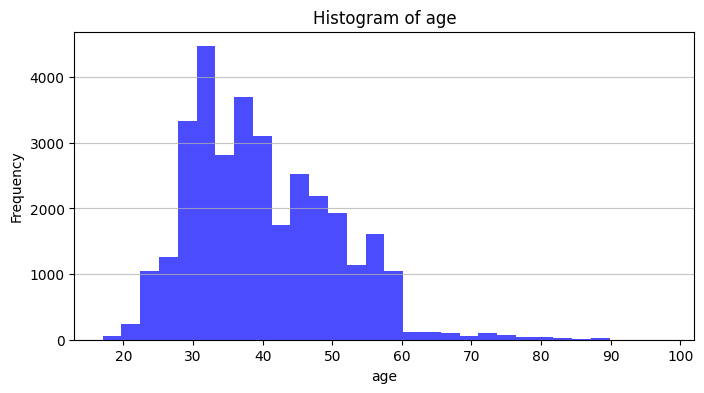

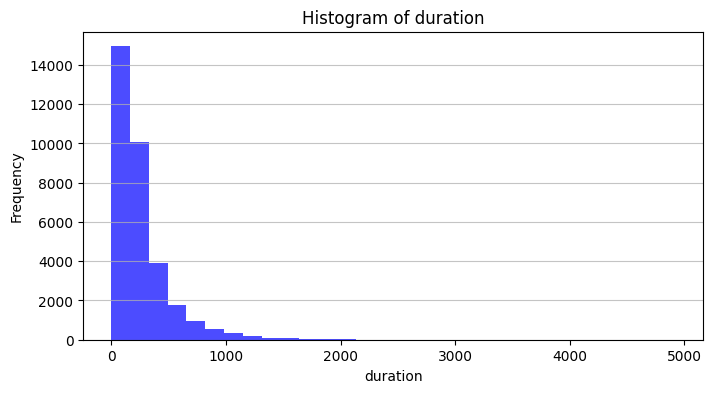

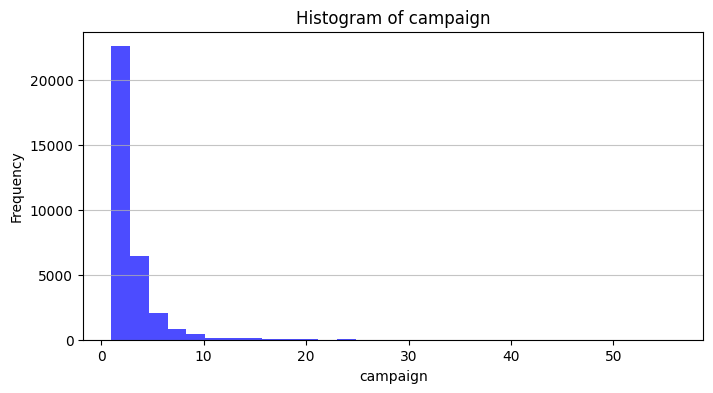

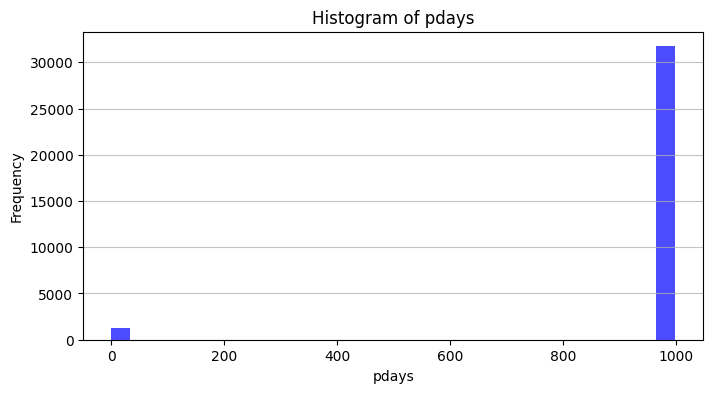

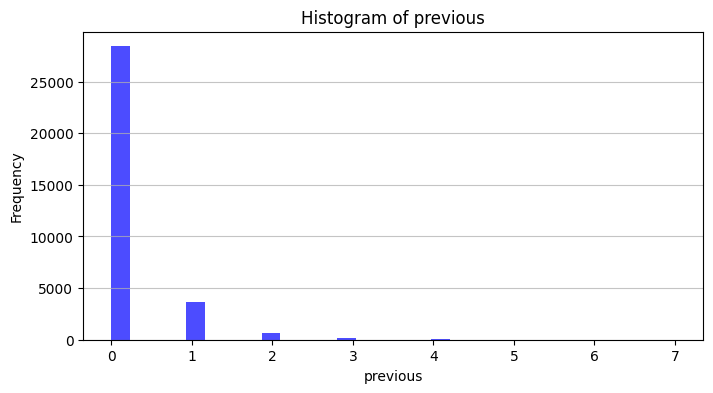

In [9]:
for column in numerical_columns:
    plt.figure(figsize=(8,4))
    plt.hist(df[column].dropna(), bins=30, color='blue', alpha=0.7)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

In [10]:
# data preparation checks
print(df.isnull().sum())

age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
y              0
dtype: int64


In [47]:
df.y.value_counts()

y
no     29238
yes     3712
Name: count, dtype: int64

In [48]:
df['y'] = df['y'].map({'yes': 1, 'no': 0})

In [56]:
round(df.y.value_counts(normalize=True), 2)

y
0    0.89
1    0.11
Name: proportion, dtype: float64

## 3. Split data (train/validation/test)

Typical split: 60% training, 20% validation and 20% test.

In [49]:
# train test split
    
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

df_train.shape, df_val.shape, df_test.shape

((19770, 16), (6590, 16), (6590, 16))

In [50]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

## 4. EDA and Future Importance

We review correlations and future importance for the variables. Also, rate ratio of target variable

In [51]:
# correlation analysis

x_var = []
y_var = []
correl = []

df_corr = df_train.copy()
for x in df_corr[numerical_columns].corr().index:
    for y in df_corr[numerical_columns].corr().columns:
        if x != y:
            x_var.append(x)
            y_var.append(y)
            correl.append(df_corr[numerical_columns].corr().loc[x, y])

correlation_df = pd.DataFrame({'x': x_var, 'y': y_var, 'correlation': correl})
correlation_df = correlation_df.sort_values(by='correlation', ascending=False)
correlation_df.drop_duplicates(subset=['correlation'], inplace=True)
correlation_df.reset_index(drop=True, inplace=True)
correlation_df.head(15)

,x,y,correlation
0,campaign,pdays,0.056276
1,previous,duration,0.026601
2,age,previous,0.020380
3,campaign,age,0.007057
4,age,duration,-0.001639
5,pdays,age,-0.022392
6,duration,pdays,-0.052105
7,campaign,previous,-0.079468
8,campaign,duration,-0.082693
9,pdays,previous,-0.588265


There is a negative correlation between variable `pdays` and `previous`, so we can delete one of them.

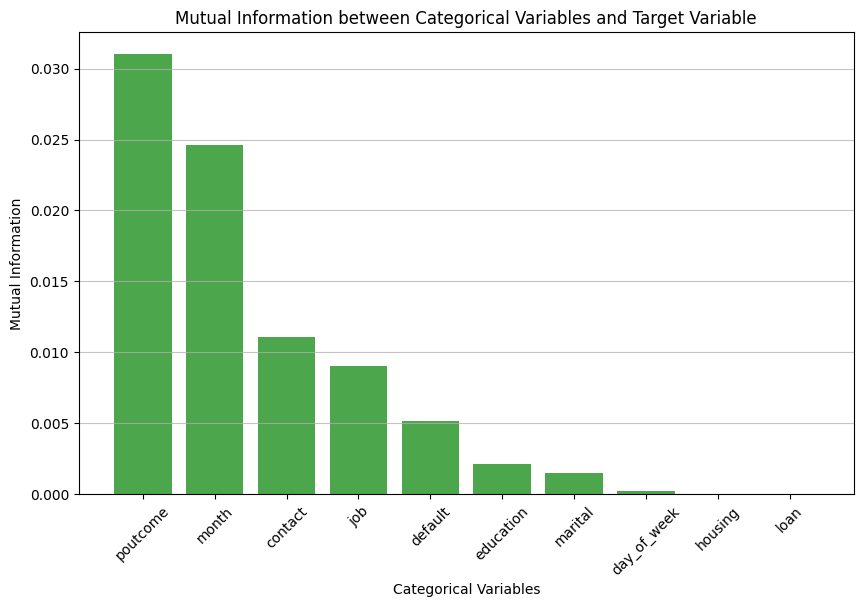

In [52]:
# mutual information for categorical variables

# categorical_columns.remove('y')

list_mutual_info = []
for c in categorical_columns:
    mi = mutual_info_score(df_train['y'], df_train[c])
    list_mutual_info.append((c, mi))

mutual_info_df = pd.DataFrame(list_mutual_info, columns=['variable', 'mutual_information'])
mutual_info_df = mutual_info_df.sort_values(by='mutual_information', ascending=False)
mutual_info_df.reset_index(drop=True, inplace=True)

# plot mutual information
plt.figure(figsize=(10,6))
plt.bar(mutual_info_df['variable'], mutual_info_df['mutual_information'], color='green', alpha=0.7)
plt.title('Mutual Information between Categorical Variables and Target Variable')
plt.xlabel('Categorical Variables')
plt.ylabel('Mutual Information')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()

In [53]:
# Function to calculate IQR and detect outliers
def detect_outliers_iqr(data, columns):
    outliers = {}
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    return outliers

outliers = detect_outliers_iqr(df_train, numerical_columns)

# Display the number of outliers in each column
for col, outlier_data in outliers.items():
    print(f"{col}: {len(outlier_data)} outliers detected")

age: 226 outliers detected
duration: 1411 outliers detected
campaign: 1176 outliers detected
pdays: 730 outliers detected
previous: 2649 outliers detected


In [54]:
for col, outlier_data in outliers.items():
    if not outlier_data.empty:
        print("Min Value for column "+str(col)+":", outlier_data[col].min())

Min Value for column age: 70
Min Value for column duration: 645
Min Value for column campaign: 7
Min Value for column pdays: 0
Min Value for column previous: 1


In [37]:
print(df_train.shape)
df_train[~df_train.index.isin(outliers[numerical_columns[0]].index)].shape

(19770, 16)


(19544, 16)

**Rate ratio target variable**

In [ ]:
print(100*np.round(df_full_train['y'].mean(),2))
print(100*np.round(df_full_train['y'].mean(),2))

11.0
11.0


In [63]:
print("Long term deposit rate general: ", np.round(df_full_train.y.mean(),2))
print("-------------------------------")
print("Long term deposit rate for unknown default: ", np.round(df_full_train[df_full_train['default']=='unknown'].y.mean(),2))
print("Long term deposit rate for no default: ", np.round(df_full_train[df_full_train['default']=='no'].y.mean(),2))
print("Long term deposit rate for yes default: ", np.round(df_full_train[df_full_train['default']=='yes'].y.mean(),2))
print("-------------------------------")
print("Long term deposit rate for failure: ", np.round(df_full_train[df_full_train['poutcome']=='failure'].y.mean(),2))
print("Long term deposit rate for success: ", np.round(df_full_train[df_full_train['poutcome']=='success'].y.mean(),2))
print("Long term deposit rate for nonexistent: ", np.round(df_full_train[df_full_train['poutcome']=='nonexistent'].y.mean(),2))

Long term deposit rate general:  0.11
-------------------------------
Long term deposit rate for unknown default:  0.05
Long term deposit rate for no default:  0.13
Long term deposit rate for yes default:  0.0
-------------------------------
Long term deposit rate for failure:  0.14
Long term deposit rate for success:  0.64
Long term deposit rate for nonexistent:  0.09


## 5. Model selection

The models trained are:

+ Logistic Regression
+ Random Frorest Classsifier
+ XGB Classsifier

According to the correlation, we are going to delete variable `pdays`.

In [64]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

# eliminate pdays due to correlation analysis
df_train.drop(['y', 'pdays'], axis=1, inplace=True)
df_val.drop(['y', 'pdays'], axis=1, inplace=True)
df_test.drop(['y', 'pdays'], axis=1, inplace=True)

### Linear Regression

To get best model we are going to use different variables and tunning hyperparameters

In [81]:
def model_regression(df_train, y_train, C=1.0):
    dv = DictVectorizer(sparse=False)
    train_dicts = df_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    return dv, model

def evaluate_model(dv, model, df_val, y_val):
    
    val_dicts = df_val.to_dict(orient='records')
    X_val = dv.transform(val_dicts)

    y_pred = model.predict_proba(X_val)[:, 1]
    churn_decision = (y_pred >= 0.5)
    accuracy = (churn_decision == y_val).mean()
    
    return accuracy, y_pred

In [78]:
# original accuracy
dv, model = model_regression(df_train, y_train, C=1.0)
orig_accuracy = evaluate_model(dv, model, df_val, y_val)
print("Original accuracy:", orig_accuracy)

accuracy_results = {}

for column_drop in df_train.columns:
    df_train_temp = df_train.drop(columns=[column_drop])
    dv, model = model_regression(df_train_temp, y_train)
    df_val_temp = df_val.drop(columns=[column_drop])
    accuracy, _ = evaluate_model(dv, model, df_val_temp, y_val)
    accuracy_results[column_drop] = accuracy
    print(f'Dropping {column_drop}, accuracy: {accuracy.round(3)}')

df_accuracy = pd.DataFrame.from_dict(accuracy_results, orient='index', columns=['accuracy'])
df_accuracy['accuracy_diff'] = df_accuracy['accuracy'] - orig_accuracy
df_accuracy = df_accuracy.sort_values(by='accuracy_diff')

df_accuracy.head(10)

Original accuracy: 0.9015174506828528
Dropping age, accuracy: 0.9
Dropping job, accuracy: 0.901
Dropping marital, accuracy: 0.901
Dropping education, accuracy: 0.901
Dropping default, accuracy: 0.901
Dropping housing, accuracy: 0.901
Dropping loan, accuracy: 0.901
Dropping contact, accuracy: 0.901
Dropping month, accuracy: 0.9
Dropping day_of_week, accuracy: 0.901
Dropping duration, accuracy: 0.891
Dropping campaign, accuracy: 0.901
Dropping previous, accuracy: 0.901
Dropping poutcome, accuracy: 0.897


,accuracy,accuracy_diff
duration,0.890895,-0.010622
poutcome,0.896662,-0.004856
month,0.899545,-0.001973
age,0.900152,-0.001366
default,0.900607,-0.000910
contact,0.900759,-0.000759
campaign,0.900759,-0.000759
previous,0.900910,-0.000607
day_of_week,0.901062,-0.000455
job,0.901214,-0.000303


In [77]:
accuracy_results_C = {}
for C in [0.01, 0.1, 1, 10, 100]:
    dv, model = model_regression(df_train, y_train, C=C)
    accuracy = evaluate_model(dv, model, df_val, y_val)
    print(f'C={C}, accuracy: {accuracy}')
    accuracy_results_C[C] = round(accuracy, 3)
    
df_accuracy_C = pd.DataFrame.from_dict(accuracy_results_C, orient='index', columns=['accuracy'])
df_accuracy_C = df_accuracy_C.sort_values(by='accuracy', ascending=False)
df_accuracy_C

C=0.01, accuracy: 0.8966616084977238
C=0.1, accuracy: 0.9006069802731411
C=1, accuracy: 0.9015174506828528
C=10, accuracy: 0.9015174506828528
C=100, accuracy: 0.9015174506828528


,accuracy
1.00,0.902
10.00,0.902
100.00,0.902
0.10,0.901
0.01,0.897


In [100]:
feature_importances = {}
for feature in ['age', 'duration', 'campaign', 'previous']:

    dv, model = model_regression(df_train[[feature]], y_train, C=1.0)
    accuracy, y_pred = evaluate_model(dv, model, df_val[[feature]], y_val)
    
    # Calculate ROC AUC
    auc_score = roc_auc_score(y_val, y_pred)
    feature_importances[feature] = auc_score

sorted_features = sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)

print("Feature Importance based on Individual ROC AUC:")
for feature, auc in sorted_features:
    print(f"{feature}: {auc:.4f}")

Feature Importance based on Individual ROC AUC:
duration: 0.8180
previous: 0.5903
campaign: 0.5536
age: 0.5111


In [132]:
feature_selection = ['duration', 'previous', 'campaign', 'age',
                     'poutcome', 'month', 'contact', 'job', 'default',
                     'education', 'marital']

dv, model = model_regression(df_train[feature_selection], y_train, C=0.01)
accuracy, y_pred = evaluate_model(dv, model, df_val[feature_selection], y_val)
print("Final model accuracy:", accuracy)

Final model accuracy: 0.8858118361153262


In [129]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 0.01, 0.1, 1]):

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train_aux = df_full_train.iloc[train_idx]
        df_val_aux = df_full_train.iloc[val_idx]
        
        y_train = df_train_aux.y.values
        y_val = df_val_aux.y.values

        dv, model = model_regression(df_train_aux[feature_selection], y_train, C=C)
        accuracy, y_pred = evaluate_model(dv, model, df_val_aux[feature_selection], y_val)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 20%|██        | 1/5 [00:00<00:01,  2.12it/s]

C=1e-06 0.673 +- 0.012


 40%|████      | 2/5 [00:00<00:01,  2.06it/s]

C=0.001 0.842 +- 0.008


 60%|██████    | 3/5 [00:01<00:01,  1.98it/s]

C=0.01 0.908 +- 0.006


 80%|████████  | 4/5 [00:02<00:00,  1.92it/s]

C=0.1 0.913 +- 0.005


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

C=1 0.913 +- 0.005
